# Convolutional Neural Network (CNN)

To obtain deterministic results (identical training results), each run has to start from the below.

In [339]:
# Ensure deterministic results
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [340]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import tensorflow as tf
import keras

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

import keras.backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding, Dropout, AveragePooling1D, BatchNormalization
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TimothyKoei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\TimothyKoei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [341]:
# Ensure deterministic results
seed = 4248

# os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [342]:
train_df = pd.read_json('../train.jsonl', lines=True)
X_train = train_df['string']
y_train = train_df['label']

dev_df = pd.read_json('../dev.jsonl', lines=True)
X_dev = dev_df['string']
y_dev = dev_df['label']

test_df = pd.read_json('../test.jsonl', lines=True)
X_test = test_df['string']
y_test = test_df['label']

train_df

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175.0,Introduction,168.0,"However, how frataxin interacts with the Fe-S ...",background,1.0000,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36.0,Novel Quantitative Trait Loci for Seminal Root...,16.0,"In the study by Hickey et al. (2012), spikes w...",background,1.0000,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228.0,Introduction,225.0,"The drug also reduces catecholamine secretion,...",background,1.0000,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110.0,Discussion,46.0,By clustering with lowly aggressive close kin ...,background,1.0000,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239.0,Discussion,234.0,Ophthalmic symptoms are rare manifestations of...,background,1.0000,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8238,explicit,50.0,,28.0,"Importantly, the results of Pascalis et al. (2...",background,0.7350,6f68ccd37718366c40ae6aeedf0b935bf560b215,60ed4bdabf92b2fbd6162dbd8979888cccca55d7,True,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,6f68ccd37718366c40ae6aeedf0b935bf560b215>60ed4...,15,NaN,NaN
8239,explicit,182.0,DISCUSSION,179.0,"As suggested by Nguena et al, there is a need ...",background,0.7508,f2a1c1704f9587c94ed95bc98179dc499e933f5e,574e659da7f6c62c07bfaaacd1f31d65bd75524c,True,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,f2a1c1704f9587c94ed95bc98179dc499e933f5e>574e6...,1,NaN,NaN
8240,explicit,120.0,DISCUSSION,108.0,Skeletal muscle is also a primary site of dise...,background,1.0000,18c97ea2ff60c110cc2a523e0fdf729608cbb083,fc13b9c3dfcc121013edaa12fa8ce7842aaed21a,False,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,18c97ea2ff60c110cc2a523e0fdf729608cbb083>fc13b...,8,NaN,NaN
8241,explicit,221.0,,185.0,ACTIVATION OF TRANSCRIPTION FACTORS Roles for ...,method,NaN,4ec9b89857c0b27e8a4bd3745b7358f387773527,81affdba19e38e2b17cf7b9e93792cc2028cf21d,True,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,4ec9b89857c0b27e8a4bd3745b7358f387773527>81aff...,0,NaN,NaN


In [343]:
def cleaning(text):
    stop_words = stopwords.words('english')
    text = text.lower()
    text = ' '.join(x for x in text.split() if x not in stop_words)
    return text

In [344]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = []
    for x in text.split():
        x = lemmatizer.lemmatize(x)
        words.append(x)
    text = ' '.join(words)
    return text

In [345]:
def preprocessing(text):
    # Tokenization
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    text = cleaning(text)
    text = lemmatize(text)
    text = ' '.join(tokenizer.tokenize(text))
    return text

In [346]:
def augment_data_multiclass(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class_size = df['label'].value_counts().max()
    upsampled_dataframes = []
    for class_label in df['label'].unique():
        class_df = df[df['label'] == class_label]
        if len(class_df) < majority_class_size:
            class_df_upsampled = resample(class_df, replace=True, n_samples=majority_class_size, random_state=10)
            upsampled_dataframes.append(class_df_upsampled)
        else:
            upsampled_dataframes.append(class_df)
    upsampled_df = pd.concat(upsampled_dataframes)
    return upsampled_df['string'], upsampled_df['label']

In [347]:
X_train, y_train = augment_data_multiclass(X_train, y_train)

In [348]:
X_train_preprocessed = X_train.apply(lambda x: preprocessing(x))
X_dev_preprocessed = X_dev.apply(lambda x: preprocessing(x))
X_test_preprocessed = X_test.apply(lambda x: preprocessing(x))

# Feature Extraction

In [349]:
num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

In [350]:
X_train_tokenized = tokenizer.texts_to_sequences(X_train_preprocessed)
X_dev_tokenized = tokenizer.texts_to_sequences(X_dev_preprocessed)
X_test_tokenized = tokenizer.texts_to_sequences(X_test_preprocessed)

In [351]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

29836

In [352]:
initial_data = [X_train_tokenized, X_dev_tokenized, X_test_tokenized]
longest_length = -1
for dataset in initial_data:
    for arr in dataset:
        if len(arr) > longest_length:
            longest_length = len(arr)

longest_length

250

In [353]:
max_words = 250
X_train_padded = sequence.pad_sequences(X_train_tokenized, maxlen=max_words, padding='pre')
X_dev_padded = sequence.pad_sequences(X_dev_tokenized, maxlen=max_words, padding='pre')
X_test_padded = sequence.pad_sequences(X_test_tokenized, maxlen=max_words, padding='pre')

# Model

## Using GloVe

Utilize GLoVe Word Embeddings, created by Stanford. Download link can be found in [here](!http://nlp.stanford.edu/data/glove.6B.zip).

In [354]:
# http://nlp.stanford.edu/data/glove.6B.zip
embeddings_dictionary = dict()
f = open('../glove.6B/glove.6B.100d.txt', encoding="utf8")
for line in f.readlines():
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
f.close()

In [355]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
            
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.1529    , -0.24279   ,  0.89837003, ..., -0.59100002,
         1.00390005,  0.20664001],
       ...,
       [ 0.13266   ,  0.025495  , -0.35374001, ...,  0.037078  ,
        -0.54132003,  0.14563   ],
       [-0.60499001,  0.52837002,  0.29420999, ..., -0.37286001,
        -0.26356   ,  0.92654002],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Convert string outputs into integer labels.

In [356]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform string column
y_train = label_encoder.fit_transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)

print(y_train)

[0 0 0 ... 2 2 2]


Here, we define a function to calculate precision and recall for 3 class classification, through macro averaging.

$$
Precision_{\text{MacroAverage}} = \frac{Precision_0 + Precision_1 + Precision_2}{3}
$$

$$
Recall_{\text{MacroAverage}} = \frac{Recall_0 + Recall_1 + Recall_2}{3}
$$

In [357]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [358]:
# Initializing CNN
model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_words, trainable=False))
model.add(BatchNormalization())

model.add(Conv1D(80, 3, padding='same', activation='relu', bias_regularizer=regularizers.l2(0.001), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Conv1D(70, 3, padding='same', activation='linear', bias_regularizer=regularizers.l2(0.001), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())

model.add(Conv1D(120, 3, padding='same', activation='relu', bias_regularizer=regularizers.l2(0.001), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Conv1D(256, 3, padding='same', activation='relu', bias_regularizer=regularizers.l2(0.001), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Flatten())

model.add(Dense(400, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization()) 
model.add(Dropout(0.4, seed=4248))

model.add(Dense(200, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4, seed=4248))

model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4, seed=4248))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)))

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', f1])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 250, 100)          2983600   
                                                                 
 batch_normalization_162 (B  (None, 250, 100)          400       
 atchNormalization)                                              
                                                                 
 conv1d_70 (Conv1D)          (None, 250, 80)           24080     
                                                                 
 batch_normalization_163 (B  (None, 250, 80)           320       
 atchNormalization)                                              
                                                                 
 max_pooling1d_47 (MaxPooli  (None, 125, 80)           0         
 ng1D)                                                           
                                                     

Training the model.

Note that a batch size of 256 and 250 epochs take about 70 minutes.

In [359]:
history = model.fit(X_train_padded, 
          y_train, 
          validation_data=(X_dev_padded, y_dev), 
          epochs=250, 
          batch_size=256, 
          verbose=2)

Epoch 1/250
57/57 - 44s - loss: 1.8121 - accuracy: 0.3510 - f1: 0.7338 - val_loss: 2.3599 - val_accuracy: 0.5873 - val_f1: 0.1936 - 44s/epoch - 777ms/step
Epoch 2/250
57/57 - 32s - loss: -4.5786e-01 - accuracy: 0.3946 - f1: 0.7500 - val_loss: 2.6706 - val_accuracy: 0.5841 - val_f1: 0.2386 - 32s/epoch - 568ms/step
Epoch 3/250
57/57 - 17s - loss: -3.6367e+00 - accuracy: 0.4275 - f1: 0.7857 - val_loss: 4.0185 - val_accuracy: 0.5895 - val_f1: 0.1702 - 17s/epoch - 294ms/step
Epoch 4/250
57/57 - 18s - loss: -6.9911e+00 - accuracy: 0.4379 - f1: 0.7951 - val_loss: 4.1951 - val_accuracy: 0.5895 - val_f1: 0.2587 - 18s/epoch - 312ms/step
Epoch 5/250
57/57 - 17s - loss: -1.0304e+01 - accuracy: 0.4326 - f1: 0.7880 - val_loss: 4.2512 - val_accuracy: 0.5753 - val_f1: 0.3347 - 17s/epoch - 302ms/step
Epoch 6/250
57/57 - 17s - loss: -1.3783e+01 - accuracy: 0.4347 - f1: 0.7895 - val_loss: 2.2377 - val_accuracy: 0.5644 - val_f1: 0.4438 - 17s/epoch - 296ms/step
Epoch 7/250
57/57 - 17s - loss: -1.7480e+01 -

In [360]:
scores = model.evaluate(X_test_padded, y_test)

print(f"Accuracy: {scores[1] * 100}%")
print(f"F1-Score: {scores[2] * 100}%")

59/59 [==============================] - 2s 39ms/step - loss: -970.7175 - accuracy: 0.6480 - f1: 0.7073
Accuracy: 64.80386853218079%
F1-Score: 70.73119282722473%


In [361]:
# With reference to https://realpython.com/python-keras-text-classification/#your-first-keras-model
# Plotting histogram
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

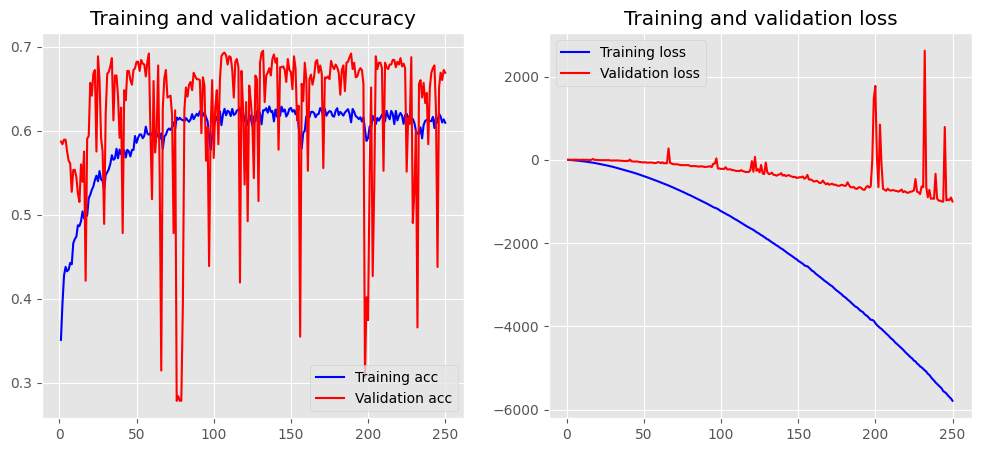

In [362]:
plot_history(history)
# history.history